Project4-Nest_Net
===
---

#### 목표
UNet과 Nest_Net(Unet++)의 모델을 논문을 보며 직접 구현해보고 KITTI데이터셋을 넣어 세그멘테이션 결과를 분석해보자 

#### 사용한 데이터셋
    - KITTI
#### 사용한 모델
    - UNet
    - Nets Net(Unet ++)
    
    
    
    
    
    
    
### 환경설정

#### 라이브러리 로드

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


#### GPU 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터 로더 만들기

입력값 :: (224, 224)
출력값 :: (224, 224)

#### Albumentation을 통한 augmentation

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                    Resize(
                        width=224,
                        height=224
                        )
                    ])

#### agumentation 확인해보기

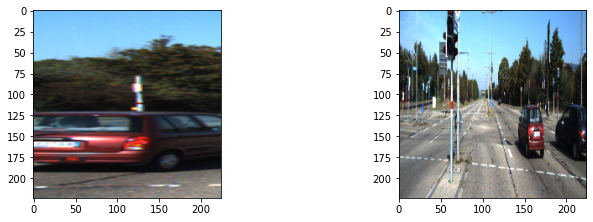

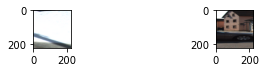

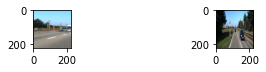

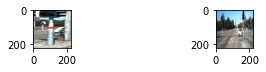

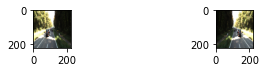

In [4]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    plt.show()

#### KittiGenerator 만들기

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

#### train data와 test data에 대해 agumentation 적용해주기

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Unet 모델

![image](https://user-images.githubusercontent.com/70703320/115952432-d3730880-a520-11eb-83ca-6d042afdf542.png)

전체적인 모델 구조

In [7]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### 학습

In [8]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

/home/aiffel-dj63/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
11/11 [==============================] - 34s 634ms/step - loss: 0.6752 - val_loss: 0.5259
Epoch 2/100
11/11 [==============================] - 6s 565ms/step - loss: 0.4155 - val_loss: 0.3886
Epoch 3/100
11/11 [==============================] - 6s 565ms/step - loss: 0.3283 - val_loss: 0.3714
Epoch 4/100
11/11 [==============================] - 7s 594ms/step - loss: 0.3129 - val_loss: 0.3682
Epoch 5/100
11/11 [==============================] - 6s 571ms/step - loss: 0.3066 - val_loss: 0.3096
Epoch 6/100
11/11 [==============================] - 6s 565ms/step - loss: 0.3442 - val_loss: 0.3128
Epoch 7/100
11/11 [==============================] - 6s 566ms/step - loss: 0.2768 - val_loss: 0.2975
Epoch 8/100
11/11 [==============================] - 6s 570ms/step - loss: 0.2710 - val_loss: 0.2902
Epoch 9/100
11/11 [==============================] - 7s 636ms/step - loss: 0.2297 - val_loss: 0.2969
Epoch 10/100
11/11 [==============================] - 6s 571ms/step - loss: 0.2579 - val_l

11/11 [==============================] - 9s 756ms/step - loss: 0.1075 - val_loss: 0.1447
Epoch 82/100
11/11 [==============================] - 9s 796ms/step - loss: 0.1166 - val_loss: 0.1739
Epoch 83/100
11/11 [==============================] - 9s 793ms/step - loss: 0.1114 - val_loss: 0.2209
Epoch 84/100
11/11 [==============================] - 9s 782ms/step - loss: 0.1050 - val_loss: 0.1988
Epoch 85/100
11/11 [==============================] - 7s 634ms/step - loss: 0.1065 - val_loss: 0.1590
Epoch 86/100
11/11 [==============================] - 7s 627ms/step - loss: 0.0949 - val_loss: 0.1695
Epoch 87/100
11/11 [==============================] - 7s 590ms/step - loss: 0.0872 - val_loss: 0.1944
Epoch 88/100
11/11 [==============================] - 7s 579ms/step - loss: 0.0940 - val_loss: 0.1470
Epoch 89/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0849 - val_loss: 0.1384
Epoch 90/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0915 - val_loss: 

#### IOU score를 얻는 함수

In [9]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

#### 결과를 얻는 함수

In [10]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### IoU값 구하기

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.865279


0.86527884146766

### 결과 확인

![U_Net](https://user-images.githubusercontent.com/70703320/115966693-bd3d6a80-a569-11eb-8852-5aded063fdb1.png)

## Nest_Net

#### agumentation 적용

In [12]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path,
    batch_size=4,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

#### model block 만들어주기

In [13]:
def conv_unit(inputs, filters):
    
    conv2d = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv2d = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2d)
    
    return conv2d

#### Nest_Net 모델 쌓기

![스크린샷, 2021-04-24 17-17-39](https://user-images.githubusercontent.com/70703320/115952468-13d28680-a521-11eb-80b7-8c59059e953f.png)

Unet과 달리 Nest_Net은 이전 블럭들이 그물망처럼 얽혀서 계속 이어지는(skip-connection을 통해) 구조이다. 이를 구현하기 위해 아래 그림의 아래부터 위까지의 순서대로 쌓았다.

![스크린샷, 2021-04-24 17-17-54](https://user-images.githubusercontent.com/70703320/115952511-4f6d5080-a521-11eb-96b8-9ea89b9c43aa.png)


In [14]:
from keras.regularizers import l2

def uppnet_build_model(input_shape=(224, 224, 3), num_class=1):
    
    # UNet++L1
    inputs = Input(input_shape)
    conv_x00 = conv_unit(inputs, 64)
    
    pool_x10 = MaxPooling2D(pool_size=(2, 2))(conv_x00)
    conv_x10 = conv_unit(pool_x10, 128)
    
    upsm_x01 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x10)
    cnct_x01 = Concatenate(axis=3)([upsm_x01, conv_x00])
    conv_x01 = conv_unit(cnct_x01, 64)  
    
    # UNet++L2
    pool_x20 = MaxPooling2D(pool_size=(2, 2))(conv_x10)
    conv_x20 = conv_unit(pool_x20, 256)
    
    upsm_x11 = Conv2DTranspose(128, 2, strides=(2, 2))(conv_x20)
    cnct_x11 = Concatenate(axis=3)([upsm_x11, conv_x10])
    conv_x11 = conv_unit(cnct_x11, 128)  
   
    upsm_x02 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x11)
    cnct_x02 = Concatenate(axis=3)([upsm_x02, conv_x01, conv_x00])
    conv_x02 = conv_unit(cnct_x02, 64)  
    
    # UNet++L3
    pool_x30 = MaxPooling2D(pool_size=(2, 2))(conv_x20)
    conv_x30 = conv_unit(pool_x30, 512)
    
    upsm_x21 = Conv2DTranspose(256, 2, strides=(2, 2))(conv_x30)
    cnct_x21 = Concatenate(axis=3)([upsm_x21, conv_x20])
    conv_x21 = conv_unit(cnct_x21, 256)  
   
    upsm_x12 = Conv2DTranspose(128, 2, strides=(2, 2))(conv_x21)
    cnct_x12 = Concatenate(axis=3)([upsm_x12, conv_x11, conv_x10])
    conv_x12 = conv_unit(cnct_x12, 128)
    
    upsm_x03 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x12)
    cnct_x03 = Concatenate(axis=3)([upsm_x03, conv_x02, conv_x01, conv_x00])
    conv_x03 = conv_unit(cnct_x03, 64)     
    
    # UNet++L4
    pool_x40 = MaxPooling2D(pool_size=(2, 2))(conv_x30)
    conv_x40 = conv_unit(pool_x40, 1024)
    
    upsm_x31 = Conv2DTranspose(512, 2, strides=(2, 2))(conv_x40)
    cnct_x31 = Concatenate(axis=3)([upsm_x31, conv_x30])
    conv_x31 = conv_unit(cnct_x31, 512)  
   
    upsm_x22 = Conv2DTranspose(256, 2, strides=(2, 2))(conv_x31)
    cnct_x22 = Concatenate(axis=3)([upsm_x22, conv_x21, conv_x20])
    conv_x22 = conv_unit(cnct_x22, 256)
    
    upsm_x13 = Conv2DTranspose(128, 2, strides=(2, 2))(conv_x22)
    cnct_x13 = Concatenate(axis=3)([upsm_x13, conv_x12, conv_x11, conv_x10])
    conv_x13 = conv_unit(cnct_x13, 128)       

    upsm_x04 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x13)
    cnct_x04 = Concatenate(axis=3)([upsm_x04, conv_x03,conv_x02, conv_x01, conv_x00])
    conv_x04 = conv_unit(cnct_x04, 64)
    
    UppNet_Output = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv_x04)
    
    
    model = Model(inputs = inputs, outputs = UppNet_Output)
    return model

model = uppnet_build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

#### 모델 학습

In [15]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_uppnet_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 55s 470ms/step - loss: 0.6102 - val_loss: 0.4642
Epoch 2/100
43/43 [==============================] - 15s 337ms/step - loss: 0.3874 - val_loss: 0.3829
Epoch 3/100
43/43 [==============================] - 15s 339ms/step - loss: 0.2473 - val_loss: 0.3902
Epoch 4/100
43/43 [==============================] - 15s 345ms/step - loss: 0.2264 - val_loss: 0.2735
Epoch 5/100
43/43 [==============================] - 15s 355ms/step - loss: 0.2297 - val_loss: 0.2560
Epoch 6/100
43/43 [==============================] - 15s 344ms/step - loss: 0.2379 - val_loss: 0.2831
Epoch 7/100
43/43 [==============================] - 15s 346ms/step - loss: 0.1990 - val_loss: 0.2443
Epoch 8/100
43/43 [==============================] - 15s 344ms/step - loss: 0.2076 - val_loss: 0.2365
Epoch 9/100
43/43 [==============================] - 15s 345ms/step - loss: 0.2052 - val_loss: 0.2280
Epoch 10/100
43/43 [==============================] - 15s 345ms/step - loss: 0.171

43/43 [==============================] - 14s 336ms/step - loss: 0.0894 - val_loss: 0.1247
Epoch 81/100
43/43 [==============================] - 14s 336ms/step - loss: 0.1053 - val_loss: 0.1470
Epoch 82/100
43/43 [==============================] - 14s 335ms/step - loss: 0.0871 - val_loss: 0.2273
Epoch 83/100
43/43 [==============================] - 14s 335ms/step - loss: 0.1089 - val_loss: 0.1558
Epoch 84/100
43/43 [==============================] - 14s 335ms/step - loss: 0.0820 - val_loss: 0.1530
Epoch 85/100
43/43 [==============================] - 14s 335ms/step - loss: 0.0793 - val_loss: 0.1494
Epoch 86/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0742 - val_loss: 0.1623
Epoch 87/100
43/43 [==============================] - 14s 336ms/step - loss: 0.1073 - val_loss: 0.1618
Epoch 88/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0849 - val_loss: 0.1970
Epoch 89/100
43/43 [==============================] - 15s 336ms/step - loss: 0.0774 - 

#### Nest_Net의 IoU값 확인하기

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.955972


0.9559719330711697

### 결과확인

![Nest_Net](https://user-images.githubusercontent.com/70703320/115966723-d5ad8500-a569-11eb-8323-9dfaccbef972.png)

## 회고

Nest_Net을 쌓는 것의 어려움
- 이전에 ResNet을 쌓으며 Skip-Connection과 block 함수 만들기 등의 경험으로 그나마 수월하게 할 수 있었다.
- 하지만 레이어의 입력을 Add()가 아닌 Concatenate()라는 함수로 여러 개의 입력을 받아 합치는 것이 생소하였다.
- 또한, convolution layer의 입력으로 upstream2dlayer를 쓰는 것이 Conv2DTranspose를 쓰는 것과 동일함을 알 수 있게 되었다. (단, stride와 필터의 크기를 적절히 조절해주어야 한다.)

## 루브릭

KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한사이클이 정상수행되어 세그멘테이션 결과이미지를 제출하였다.

- U-Net 결과확인 부분에서 확인이 가능하다.

U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상진행되었다.

- U-Net++ 결과확인 부분에서 확인이 가능하다.

U-Net++ 의 세그멘테이션 결과 사진와 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

|결과|U-Net|U-Net++|
|:---:|:---:|:---:|
|IoU|0.865279|0.955972|
|사진|왼쪽 차량과 오른쪽 인도에서| U-Net++이 더 좋은 성능을 보임|